# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

- UPDATE: I'm using the AVE split now

In [17]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=6
# SEED=7
# SEED=8
# SEED=2

#TODO: rename to result_p 
data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

lit_pcba_full_data_p = Path(f"/p/vast1/jones289/lit_pcba/lit_pcba_full_data")


# fig_size = (12,10)
figsize = (16,18)

In [18]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)
purple_color_pal = sns.color_palette("Purples", 10)

In [19]:
model_dict = {
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
    "hdbind-rp-ecfp-1024-1-100": ("HDB-ECFP-100", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1k": ("HDB-ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1": ("HDB-ECFP", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100k": ("HDB-ECFP-100k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1m": ("HDB-ECFP-1m", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100k": ("HDB-ECFP-100k", green_color_pal[6]),
    "hdbind-rp-molclr-100":  ("HDB-MolCLR-100", green_color_pal[6]),
    "hdbind-rp-molclr-1k":  ("HDB-MolCLR-1k", green_color_pal[6]),
    "hdbind-rp-molclr":  ("HDB-MolCLR", green_color_pal[6]),
    "hdbind-rp-molclr-100k":  ("HDB-MolCLR-100k", green_color_pal[6]),
    "hdbind-rp-molclr-1m":  ("HDB-MolCLR-1m", green_color_pal[6]),
    "hdbind-rp-molclr-100k":  ("HDB-MolCLR-100k", green_color_pal[6]),
    "hdbind-rp-molformer-100": ("HDB-MolFormer-100", green_color_pal[6]),
    "hdbind-rp-molformer-1k": ("HDB-MolFormer-1k", green_color_pal[6]),
    "hdbind-rp-molformer": ("HDB-MolFormer", green_color_pal[6]),
    "hdbind-rp-molformer-100k": ("HDB-MolFormer-100k", green_color_pal[6]),
    "hdbind-rp-molformer-1m": ("HDB-MolFormer-1m", green_color_pal[6]),
    "hdbind-rp-molformer-ecfp-combo": ("HDB-Combo", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[6]), 
    "hdbind-directecfp-100-1": ("HDB-DECFP-100-1", green_color_pal[6]),
    "hdbind-directecfp-100-2": ("HDB-DECFP-100-2", green_color_pal[6]),
    "hdbind-directecfp-100-4": ("HDB-DECFP-100-4", green_color_pal[6]),
    "hdbind-directecfp-1k-1": ("HDB-DECFP-1k-1", green_color_pal[6]),
    "hdbind-directecfp-1k-2": ("HDB-DECFP-1k-2", green_color_pal[6]),
    "hdbind-directecfp-1k-4": ("HDB-DECFP-1k-4", green_color_pal[6]),
    "hdbind-directecfp-10k-1": ("HDB-DECFP-10k-1", green_color_pal[6]),
    "hdbind-directecfp-10k-2": ("HDB-DECFP-10k-2", green_color_pal[6]),
    "hdbind-directecfp-10k-4": ("HDB-DECFP", green_color_pal[6]),
    "hdbind-directecfp-100k-1": ("HDB-DECFP-100k-1", green_color_pal[6]),
    "hdbind-directecfp-100k-2": ("HDB-DECFP-100k-2", green_color_pal[6]),
    "hdbind-directecfp-100k-4": ("HDB-DECFP-100k-4", green_color_pal[6]),
    "hdbind-directecfp-1m-1": ("HDB-DECFP-1m-1", green_color_pal[6]),
    "hdbind-directecfp-1m-2": ("HDB-DECFP-1m-2", green_color_pal[6]),
    "hdbind-directecfp-1m-4": ("HDB-DECFP-1m-4", green_color_pal[6]),
    "hdbind-molformer-decfp-combo-1k": ("HDB-Combo-1k (new)", purple_color_pal[6]),
    "hdbind-molformer-decfp-combo": ("HDB-Combo-10k (new)", purple_color_pal[6]),
    "hdbind-molformer-decfp-combo-100k": ("HDB-Combo-100k (new)", purple_color_pal[6]),
    "hdbind-molformer-decfp-combo-1m": ("HDB-Combo-1m (new)", purple_color_pal[6]),
    "mlp-1024-1": ("MLP", blue_color_pal[7]),
    "Vina": ("Vina", "salmon"),
}

model_10k_list = [ "molehd-bpe", "hdbind-rp-ecfp-1024-1", "hdbind-rp-molclr", "hdbind-rp-molformer","hdbind-directecfp-10k-4", "hdbind-molformer-decfp-combo", "mlp-1024-1", "Vina"]

# LIT-PCBA Results

In [20]:
def aggregate_results(model_list:list, dataset:str, split:str, target_list:list):
    assert target_list is not None
    
    model_metric_dict = {"model": [], 
                        "enrich": [], 
                        "p":[], 
                        #  "train_time":[], 
                        # "test_time": [], 
                        "target": [],
                        "seed": [],
                        "roc-auc": [], 
                        # "recall": [], "precision": [], "f1": [], 
                        }

    for model_name in tqdm(model_list, total=len(model_list), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}-*-{split}*.pkl"))

        
        for path in tqdm(data_path_list, total=len(data_path_list), position=1):
            target = path.name.split(".")[1].split("-")[-2]
            print(target, path, model_name)

            if target in target_list or target_list == "all":
                pass
            else:
                continue

            try:
                model_data_dict = torch.load(path)
            except RuntimeError as e:
                print(f"{e}. moving to next file.")
                continue
            
            for seed in range(len(model_data_dict['trials'])):

                # import pdb
                # pdb.set_trace()
                trial_dict = model_data_dict['trials'][seed]


                try:
                    enrich_1 = trial_dict['enrich-1'][0]
                    enrich_10 = trial_dict['enrich-10'][0]
                    roc_auc = trial_dict["roc-auc"]



                except IndexError as e:
                    print(f"mismatched index, converting float to numpy array")
                    enrich_1 = trial_dict['enrich-1'].numpy().reshape(1)
                    model_data_dict["trials"][seed]['enrich-1'] = enrich_1 
                    enrich_10 = trial_dict['enrich-10'].numpy().reshape(1)
                    model_data_dict["trials"][seed]['enrich-10'] = enrich_10 

                    torch.save(model_data_dict, path)
                    model_data_dict = torch.load(path)                   


                except KeyError as e:

                    print(f"missing key {e} for seed {seed}. computing these now.")

                    scores = None
                    if "mlp" in model_name: 
                        scores = trial_dict["eta"][:, 1]
                    else:
                    
                        scores = trial_dict["eta"]

                    enrich_1  = compute_enrichment_factor(scores=scores, 
                                                            labels=model_data_dict["trials"][seed]["y_true"],
                                                            n_percent=.01)

                    model_data_dict["trials"][seed]["enrich-1"] = enrich_1


                    enrich_10 = compute_enrichment_factor(scores=scores,
                                                            labels=model_data_dict["trials"][seed]["y_true"],
                                                            n_percent=.1)

                    model_data_dict["trials"][seed]["enrich-10"] = enrich_10


                    torch.save(model_data_dict, path)

                    model_data_dict = torch.load(path)

                # '''
                for p in [.01, .1]:

                    if p == .01:
                        model_metric_dict["enrich"].append(enrich_1)
                    else:
                        model_metric_dict["enrich"].append(enrich_10)
                       
                    model_metric_dict["target"].append(target)
                    # model_metric_dict["test_time"].append(trial_dict["test_time"])
                    model_metric_dict["p"].append(p)
                    model_metric_dict["seed"].append(seed)
                    model_metric_dict["roc-auc"].append(roc_auc)
                    # model_metric_dict["precision"].append(metrics["precision"])
                    # model_metric_dict["recall"].append(metrics["recall"])
                    # model_metric_dict["f1"].append(metrics["f1"])
                    model_metric_dict["model"].append(model_name)


    print([key for key, value in model_metric_dict.items()])
    print([len(value) for key, value in model_metric_dict.items()])
    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

    return model_metric_df
        


# VINA result

In [21]:
def process_target(target_name="VDR", target_id="AID504847", split="ave"):



    train_actives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_active_T.smi", header=None, delim_whitespace=True) 
    test_actives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_active_V.smi", header=None, delim_whitespace=True) 
    test_actives["label"] = [1] * len(test_actives)
    train_actives["label"] = [1] * len(train_actives)

    train_inactives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_inactive_T.smi", header=None, delim_whitespace=True) 
    test_inactives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_inactive_V.smi", header=None, delim_whitespace=True) 
    test_inactives["label"] = [0] * len(test_inactives)
    train_inactives["label"] = [0] * len(train_inactives)



    print("train_actives.shape", train_actives.shape, 
        "train_inactives.shape", train_inactives.shape,
        "test_actives.shape", test_actives.shape,
        "test_inactives.shape", test_inactives.shape)

    dock_actives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-actives.csv")
    dock_actives["id"] = dock_actives[" key"].apply(lambda x: int(x.split("/")[-1]))
    dock_inactives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-inactives.csv")
    dock_inactives["id"] = dock_inactives[" key"].apply(lambda x: int(x.split("/")[-1]))


    print("dock_actives.shape", dock_actives.shape, "dock_inactives.shape",dock_inactives.shape)


    # these are the smiles and IDs for the train/test compounds for the target
    train_df = pd.concat([train_actives, train_inactives])
    train_df["id"] = train_df[1]
    test_df = pd.concat([test_actives, test_inactives])
    test_df["id"] = test_df[1]

    # import pdb
    # pdb.set_trace()

    if split == "ave":

        print("train_df.shape", train_df.shape, "test_df.shape", test_df.shape)
    else:
        
        # load a random split file from an ml result and use those smiles strings instead

        full_df = pd.concat([train_df, test_df])

        ml_result_file = torch.load(f"/p/vast1/jones289/hd_results/{SEED}/hdbind-rp-molformer.lit-pcba-{target_name}-random.{SEED}.pkl")

        test_smiles = ml_result_file['smiles_test']


        test_df = pd.merge(full_df, pd.DataFrame.from_dict({"smiles": test_smiles.tolist()}), left_on=0, right_on="smiles", how="inner")

        # import pdb
        # pdb.set_trace()

    dock_actives["dock_id"] = dock_actives[' key'].apply(lambda x: int(x.split("/")[-1]))
    dock_inactives["dock_id"] = dock_inactives[' key'].apply(lambda x: int(x.split("/")[-1]))


    print("dock_actives.shape", dock_actives.shape, "dock_inactives.shape", dock_inactives.shape)


    active_lig_map_df = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/lig_rec/lig-{target_name}-actives.csv")
    active_lig_map_df["id"] = active_lig_map_df[" key"].apply(lambda x: int(x.split("/")[-1]))


    inactive_lig_map_df = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/lig_rec/lig-{target_name}-inactives.csv")
    inactive_lig_map_df["id"] = inactive_lig_map_df[" key"].apply(lambda x: int(x.split("/")[-1]))

    print("active_lig_map_df.shape", active_lig_map_df.shape, "inactive_lig_map_df.shape", inactive_lig_map_df.shape)

    active_df = pd.merge(dock_actives, active_lig_map_df, left_on="dock_id", right_on="id")
    inactive_df = pd.merge(dock_inactives, inactive_lig_map_df, left_on="dock_id", right_on="id")

    print("active_df.shape", active_df.shape, "inactive_df.shape", inactive_df.shape)

    # train_active_df = pd.merge(active_df, train_df, left_on=" name", right_on="id")
    test_active_df = pd.merge(active_df, test_df, left_on=" name", right_on="id")
    # train_inactive_df = pd.merge(inactive_df, train_df, left_on=" name", right_on="id")
    test_inactive_df = pd.merge(inactive_df, test_df, left_on=" name", right_on="id")

    # print("train_active_df.shape", train_active_df.shape, "train_inactive_df.shape", train_inactive_df.shape)
    print("test_active_df.shape", test_active_df.shape, "test_inactive_df.shape", test_inactive_df.shape)


    # train_df = pd.concat([train_active_df, train_inactive_df])
    test_df = pd.concat([test_active_df, test_inactive_df])

    # print("train_data size ", train_df.shape, train_df["id"].unique().shape)
    print("test_data size", test_df.shape, test_df["id"].unique().shape)


    # print(train_df.head())
    # print(test_df.head())


    # import pdb 
    # pdb.set_trace()
    test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)
    test_df["target"] = [target_name] * len(test_df)


    return test_df

def load_lit_pcba_vina(split:str):
    assert split is not None

    target_tup_list = [
        ("492947", "ADRB2"),
        ("1030", "ALDH1"),
        ("743075", "ESR1_ago"),
        ("743080", "ESR1_ant"),
        ("588795", "FEN1"),
        ("2101", "GBA"),
        ("602179", "IDH1"),
        ("504327", "KAT2A"),
        ("995", "MAPK1"),
        ("493208", "MTORC1"),
        ("1777", "OPRK1"),
        ("1631", "PKM2"),
        ("743094", "PPARG"),
        ("651631", "TP53"),
        ("504847", "VDR"),
    ]


    df_list = []
    for target_id, target_name in target_tup_list:
        print(target_id, target_name) 
        target_df = process_target(target_name, target_id=f"AID{target_id}", split=split)
        df_list.append(target_df)
        print()


    df = pd.concat(df_list)

    # import pdb
    # pdb.set_trace()
    return df

In [23]:
def make_swarm_plot(model_dict, model_list, enrich_1_df, enrich_10_df, dataset:str, split:str):
    
    assert model_list is not None
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=figsize, sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    
    # enrich_f.suptitle(f"{dataset.upper()} ({split})")

    if split == "random":

        enrich_ax[0].set_title(f"Random")
    elif split == "ave":

        enrich_ax[0].set_title(f"AVE")
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=model_list,
                  palette={key: model_dict[key][1] for key in model_list},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=model_list,
                  palette={key: model_dict[key][1] for key in model_list},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-{split}-enrich.png", dpi=600, bbox_inches="tight")





def compute_model_metric_df(model_dict, model_list, dataset, split, target_list=None):
    
    assert target_list is not None
    if model_list is None:
        model_list = list(model_dict.keys()) # use all models if nothing is provided
    # docking_df = load_lit_pcba_vina(target_list=target_list, split=split)
    docking_df = load_lit_pcba_vina(split=split) # need an argument to load the data for the random splits

    
    model_metric_df = aggregate_results(model_list=model_list, dataset=dataset,
                                        split=split, target_list=target_list)
    

    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_col='min_vina'
    label_col = "label"
    for target, target_df in docking_df.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df[label_col], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)

    # takes the data extracted from the ml/hdbind methods and sticks the docking data on the bottom 
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    
    # take the average over the random seeds dimension for each combo of MODEL X TARGET X P
    grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
    grp_df = grp_df.sort_values(by="model")
    
    
    for name, group in grp_df.groupby(["model", "p"]):
        print(name)
        print(group.describe())


    make_swarm_plot(model_dict=model_dict, model_list=model_list, enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1],
             dataset=dataset, split=split)

    return model_metric_df


492947 ADRB2
train_actives.shape (13, 3) train_inactives.shape (234363, 3) test_actives.shape (4, 3) test_inactives.shape (78120, 3)
dock_actives.shape (128, 23) dock_inactives.shape (2499856, 23)
train_df.shape (234376, 4) test_df.shape (78124, 4)
dock_actives.shape (128, 24) dock_inactives.shape (2499856, 24)
active_lig_map_df.shape (16, 7) inactive_lig_map_df.shape (312482, 7)
active_df.shape (128, 31) inactive_df.shape (2499856, 31)
test_active_df.shape (32, 35) test_inactive_df.shape (624960, 35)
test_data size (624992, 35) (78124,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1030 ALDH1
train_actives.shape (4032, 3) train_inactives.shape (77606, 3) test_actives.shape (1344, 3) test_inactives.shape (25868, 3)
dock_actives.shape (57336, 23) dock_inactives.shape (1103712, 23)
train_df.shape (81638, 4) test_df.shape (27212, 4)
dock_actives.shape (57336, 24) dock_inactives.shape (1103712, 24)
active_lig_map_df.shape (7167, 7) inactive_lig_map_df.shape (137964, 7)
active_df.shape (57336, 31) inactive_df.shape (1103712, 31)
test_active_df.shape (10744, 35) test_inactive_df.shape (206944, 35)
test_data size (217688, 35) (27211,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743075 ESR1_ago
train_actives.shape (10, 3) train_inactives.shape (4188, 3) test_actives.shape (3, 3) test_inactives.shape (1395, 3)
dock_actives.shape (180, 23) dock_inactives.shape (83730, 23)
train_df.shape (4198, 4) test_df.shape (1398, 4)
dock_actives.shape (180, 24) dock_inactives.shape (83730, 24)
active_lig_map_df.shape (12, 7) inactive_lig_map_df.shape (5582, 7)
active_df.shape (180, 31) inactive_df.shape (83730, 31)
test_active_df.shape (45, 35) test_inactive_df.shape (20925, 35)
test_data size (20970, 35) (1398,)

743080 ESR1_ant
train_actives.shape (77, 3) train_inactives.shape (3711, 3) test_actives.shape (25, 3) test_inactives.shape (1237, 3)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


dock_actives.shape (1515, 23) dock_inactives.shape (74205, 23)
train_df.shape (3788, 4) test_df.shape (1262, 4)
dock_actives.shape (1515, 24) dock_inactives.shape (74205, 24)
active_lig_map_df.shape (101, 7) inactive_lig_map_df.shape (4947, 7)
active_df.shape (1515, 31) inactive_df.shape (74205, 31)
test_active_df.shape (375, 35) test_inactive_df.shape (18540, 35)
test_data size (18915, 35) (1261,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



588795 FEN1
train_actives.shape (277, 3) train_inactives.shape (266552, 3) test_actives.shape (92, 3) test_inactives.shape (88850, 3)
dock_actives.shape (368, 23) dock_inactives.shape (355401, 23)
train_df.shape (266829, 4) test_df.shape (88942, 4)
dock_actives.shape (368, 24) dock_inactives.shape (355401, 24)
active_lig_map_df.shape (368, 7) inactive_lig_map_df.shape (355401, 7)
active_df.shape (368, 31) inactive_df.shape (355401, 31)
test_active_df.shape (92, 35) test_inactive_df.shape (88850, 35)
test_data size (88942, 35) (88942,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



2101 GBA
train_actives.shape (125, 3) train_inactives.shape (222039, 3) test_actives.shape (41, 3) test_inactives.shape (74013, 3)
dock_actives.shape (990, 23) dock_inactives.shape (1776306, 23)
train_df.shape (222164, 4) test_df.shape (74054, 4)
dock_actives.shape (990, 24) dock_inactives.shape (1776306, 24)
active_lig_map_df.shape (165, 7) inactive_lig_map_df.shape (296051, 7)
active_df.shape (990, 31) inactive_df.shape (1776306, 31)
test_active_df.shape (246, 35) test_inactive_df.shape (444078, 35)
test_data size (444324, 35) (74054,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



602179 IDH1
train_actives.shape (30, 3) train_inactives.shape (271537, 3) test_actives.shape (9, 3) test_inactives.shape (90512, 3)
dock_actives.shape (532, 23) dock_inactives.shape (5068672, 23)
train_df.shape (271567, 4) test_df.shape (90521, 4)
dock_actives.shape (532, 24) dock_inactives.shape (5068672, 24)
active_lig_map_df.shape (38, 7) inactive_lig_map_df.shape (362048, 7)
active_df.shape (532, 31) inactive_df.shape (5068672, 31)
test_active_df.shape (126, 35) test_inactive_df.shape (1267168, 35)
test_data size (1267294, 35) (90521,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



504327 KAT2A
train_actives.shape (146, 3) train_inactives.shape (261411, 3) test_actives.shape (48, 3) test_inactives.shape (87137, 3)
dock_actives.shape (579, 23) dock_inactives.shape (1045641, 23)
train_df.shape (261557, 4) test_df.shape (87185, 4)
dock_actives.shape (579, 24) dock_inactives.shape (1045641, 24)
active_lig_map_df.shape (193, 7) inactive_lig_map_df.shape (348547, 7)
active_df.shape (579, 31) inactive_df.shape (1045641, 31)
test_active_df.shape (144, 35) test_inactive_df.shape (261411, 35)
test_data size (261555, 35) (87185,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



995 MAPK1
train_actives.shape (231, 3) train_inactives.shape (46972, 3) test_actives.shape (77, 3) test_inactives.shape (15657, 3)
dock_actives.shape (4605, 23) dock_inactives.shape (939420, 23)
train_df.shape (47203, 4) test_df.shape (15734, 4)
dock_actives.shape (4605, 24) dock_inactives.shape (939420, 24)
active_lig_map_df.shape (307, 7) inactive_lig_map_df.shape (62628, 7)
active_df.shape (4605, 31) inactive_df.shape (939420, 31)
test_active_df.shape (1155, 35) test_inactive_df.shape (234855, 35)
test_data size (236010, 35) (15734,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



493208 MTORC1
train_actives.shape (73, 3) train_inactives.shape (24729, 3) test_actives.shape (24, 3) test_inactives.shape (8243, 3)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:24: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dock_inactives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-inactives.csv")


dock_actives.shape (1056, 23) dock_inactives.shape (362681, 23)
train_df.shape (24802, 4) test_df.shape (8267, 4)
dock_actives.shape (1056, 24) dock_inactives.shape (362681, 24)
active_lig_map_df.shape (96, 7) inactive_lig_map_df.shape (32971, 7)
active_df.shape (1056, 31) inactive_df.shape (362681, 31)
test_active_df.shape (253, 35) test_inactive_df.shape (90662, 35)
test_data size (90915, 35) (8265,)

1777 OPRK1


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (18, 3) train_inactives.shape (202362, 3) test_actives.shape (6, 3) test_inactives.shape (67454, 3)
dock_actives.shape (23, 23) dock_inactives.shape (269815, 23)
train_df.shape (202380, 4) test_df.shape (67460, 4)
dock_actives.shape (23, 24) dock_inactives.shape (269815, 24)
active_lig_map_df.shape (23, 7) inactive_lig_map_df.shape (269815, 7)
active_df.shape (23, 31) inactive_df.shape (269815, 31)
test_active_df.shape (6, 35) test_inactive_df.shape (67454, 35)
test_data size (67460, 35) (67460,)

1631 PKM2


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (410, 3) train_inactives.shape (184143, 3) test_actives.shape (136, 3) test_inactives.shape (61380, 3)
dock_actives.shape (4905, 23) dock_inactives.shape (2209698, 23)
train_df.shape (184553, 4) test_df.shape (61516, 4)
dock_actives.shape (4905, 24) dock_inactives.shape (2209698, 24)
active_lig_map_df.shape (545, 7) inactive_lig_map_df.shape (245522, 7)
active_df.shape (4905, 31) inactive_df.shape (2209698, 31)
test_active_df.shape (1224, 35) test_inactive_df.shape (552420, 35)
test_data size (553644, 35) (61516,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743094 PPARG
train_actives.shape (21, 3) train_inactives.shape (3909, 3) test_actives.shape (6, 3) test_inactives.shape (1302, 3)
dock_actives.shape (390, 23) dock_inactives.shape (78150, 23)
train_df.shape (3930, 4) test_df.shape (1308, 4)
dock_actives.shape (390, 24) dock_inactives.shape (78150, 24)
active_lig_map_df.shape (26, 7) inactive_lig_map_df.shape (5210, 7)
active_df.shape (390, 31) inactive_df.shape (78150, 31)
test_active_df.shape (90, 35) test_inactive_df.shape (19530, 35)
test_data size (19620, 35) (1308,)

651631 TP53
train_actives.shape (60, 3) train_inactives.shape (3126, 3) test_actives.shape (19, 3) test_inactives.shape (1042, 3)
dock_actives.shape (468, 23) dock_inactives.shape (25002, 23)
train_df.shape (3186, 4) test_df.shape (1061, 4)
dock_actives.shape (468, 24) dock_inactives.shape (25002, 24)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


active_lig_map_df.shape (78, 7) inactive_lig_map_df.shape (4167, 7)
active_df.shape (468, 31) inactive_df.shape (25002, 31)
test_active_df.shape (114, 35) test_inactive_df.shape (6252, 35)
test_data size (6366, 35) (1061,)

504847 VDR


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (498, 3) train_inactives.shape (199906, 3) test_actives.shape (165, 3) test_inactives.shape (66635, 3)
dock_actives.shape (1766, 23) dock_inactives.shape (710774, 23)
train_df.shape (200404, 4) test_df.shape (66800, 4)
dock_actives.shape (1766, 24) dock_inactives.shape (710774, 24)
active_lig_map_df.shape (883, 7) inactive_lig_map_df.shape (355387, 7)
active_df.shape (1766, 31) inactive_df.shape (710774, 31)
test_active_df.shape (330, 35) test_inactive_df.shape (133270, 35)
test_data size (133600, 35) (66800,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


  0%|          | 0/8 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2-ave.5.pkl molehd-bpe
ALDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ALDH1-ave.5.pkl molehd-bpe


ESR1_ago /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-ave.5.pkl molehd-bpe
ESR1_ant /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-ave.5.pkl molehd-bpe
FEN1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-FEN1-ave.5.pkl molehd-bpe


GBA /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-GBA-ave.5.pkl molehd-bpe
IDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-IDH1-ave.5.pkl molehd-bpe
KAT2A /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-KAT2A-ave.5.pkl molehd-bpe


MAPK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-ave.5.pkl molehd-bpe
MTORC1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-ave.5.pkl molehd-bpe
OPRK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-OPRK1-ave.5.pkl molehd-bpe


PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-ave.5.pkl molehd-bpe
PPARG /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-ave.5.pkl molehd-bpe
TP53 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-ave.5.pkl molehd-bpe
VDR /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-VDR-ave.5.pkl molehd-bpe


 12%|█▎        | 1/8 [00:01<00:11,  1.63s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1
ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1


ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1


GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1
IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1
KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1


PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1
PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1


 25%|██▌       | 2/8 [00:03<00:09,  1.64s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-molclr


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-molclr
ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-molclr
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-molclr
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-FEN1-ave.5.pkl hdbind-rp-molclr


GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-GBA-ave.5.pkl hdbind-rp-molclr
IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-IDH1-ave.5.pkl hdbind-rp-molclr


KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-molclr


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-molclr
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-molclr
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-molclr


PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-PKM2-ave.5.pkl hdbind-rp-molclr


PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-PPARG-ave.5.pkl hdbind-rp-molclr
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-TP53-ave.5.pkl hdbind-rp-molclr
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-VDR-ave.5.pkl hdbind-rp-molclr


 38%|███▊      | 3/8 [00:05<00:09,  1.99s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-molformer


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-molformer
ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-molformer
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-molformer
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-ave.5.pkl hdbind-rp-molformer


GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-ave.5.pkl hdbind-rp-molformer


IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-ave.5.pkl hdbind-rp-molformer


KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-molformer


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-molformer
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-molformer
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-molformer


PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-ave.5.pkl hdbind-rp-molformer


PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-ave.5.pkl hdbind-rp-molformer
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-ave.5.pkl hdbind-rp-molformer
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-ave.5.pkl hdbind-rp-molformer


 50%|█████     | 4/8 [00:08<00:09,  2.43s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-ADRB2-ave.5.pkl hdbind-directecfp-10k-4


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-ALDH1-ave.5.pkl hdbind-directecfp-10k-4
ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-ESR1_ago-ave.5.pkl hdbind-directecfp-10k-4
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-ESR1_ant-ave.5.pkl hdbind-directecfp-10k-4
FEN1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-FEN1-ave.5.pkl hdbind-directecfp-10k-4


GBA /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-GBA-ave.5.pkl hdbind-directecfp-10k-4


IDH1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-IDH1-ave.5.pkl hdbind-directecfp-10k-4


KAT2A /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-KAT2A-ave.5.pkl hdbind-directecfp-10k-4


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-MAPK1-ave.5.pkl hdbind-directecfp-10k-4
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-MTORC1-ave.5.pkl hdbind-directecfp-10k-4
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-OPRK1-ave.5.pkl hdbind-directecfp-10k-4


PKM2 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-PKM2-ave.5.pkl hdbind-directecfp-10k-4
PPARG /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-PPARG-ave.5.pkl hdbind-directecfp-10k-4
TP53 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-TP53-ave.5.pkl hdbind-directecfp-10k-4
VDR /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-VDR-ave.5.pkl hdbind-directecfp-10k-4


 62%|██████▎   | 5/8 [00:11<00:07,  2.38s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-ADRB2-ave.5.pkl hdbind-molformer-decfp-combo


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-ALDH1-ave.5.pkl hdbind-molformer-decfp-combo
ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-ESR1_ago-ave.5.pkl hdbind-molformer-decfp-combo
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-ESR1_ant-ave.5.pkl hdbind-molformer-decfp-combo
FEN1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-FEN1-ave.5.pkl hdbind-molformer-decfp-combo


GBA /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-GBA-ave.5.pkl hdbind-molformer-decfp-combo


IDH1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-IDH1-ave.5.pkl hdbind-molformer-decfp-combo


KAT2A /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-KAT2A-ave.5.pkl hdbind-molformer-decfp-combo


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-MAPK1-ave.5.pkl hdbind-molformer-decfp-combo
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-MTORC1-ave.5.pkl hdbind-molformer-decfp-combo
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-OPRK1-ave.5.pkl hdbind-molformer-decfp-combo


PKM2 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-PKM2-ave.5.pkl hdbind-molformer-decfp-combo
PPARG /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-PPARG-ave.5.pkl hdbind-molformer-decfp-combo
TP53 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-TP53-ave.5.pkl hdbind-molformer-decfp-combo
VDR /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-VDR-ave.5.pkl hdbind-molformer-decfp-combo


 75%|███████▌  | 6/8 [00:13<00:04,  2.43s/it]

ADRB2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ADRB2-ave.5.pkl mlp-1024-1
ALDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ALDH1-ave.5.pkl mlp-1024-1
ESR1_ago /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl mlp-1024-1
ESR1_ant /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl mlp-1024-1
FEN1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-FEN1-ave.5.pkl mlp-1024-1


GBA /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-GBA-ave.5.pkl mlp-1024-1
IDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-IDH1-ave.5.pkl mlp-1024-1


KAT2A /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-KAT2A-ave.5.pkl mlp-1024-1


 53%|█████▎    | 8/15 [00:01<00:01,  7.00it/s]

MAPK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MAPK1-ave.5.pkl mlp-1024-1
MTORC1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MTORC1-ave.5.pkl mlp-1024-1
OPRK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-OPRK1-ave.5.pkl mlp-1024-1


PKM2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PKM2-ave.5.pkl mlp-1024-1
PPARG /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PPARG-ave.5.pkl mlp-1024-1
TP53 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-TP53-ave.5.pkl mlp-1024-1
VDR /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-VDR-ave.5.pkl mlp-1024-1


100%|██████████| 15/15 [00:01<00:00,  9.53it/s]
0it [00:00, ?it/s]/8 [00:15<00:02,  2.15s/it]
100%|██████████| 8/8 [00:15<00:00,  1.90s/it]


['model', 'enrich', 'p', 'target', 'seed', 'roc-auc']
[2100, 2100, 2100, 2100, 2100, 2100]
('Vina', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   2.405046
std     0.00   2.295705
min     0.01   0.000000
25%     0.01   0.951580
50%     0.01   1.572884
75%     0.01   3.332360
max     0.01   7.746193
('Vina', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   1.446403
std    2.872975e-17   0.588916
min    1.000000e-01   0.000000
25%    1.000000e-01   1.254643
50%    1.000000e-01   1.505012
75%    1.000000e-01   1.812046
max    1.000000e-01   2.173718
('hdbind-directecfp-10k-4', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   7.638491
std     0.00   8.380955
min     0.01   0.000000
25%     0.01   1.982587
50%     0.01   5.076555
75%     0.01  10.550711
max     0.01  30.849448
('hdbind-directecfp-10k-4', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   3.028176
std    2.

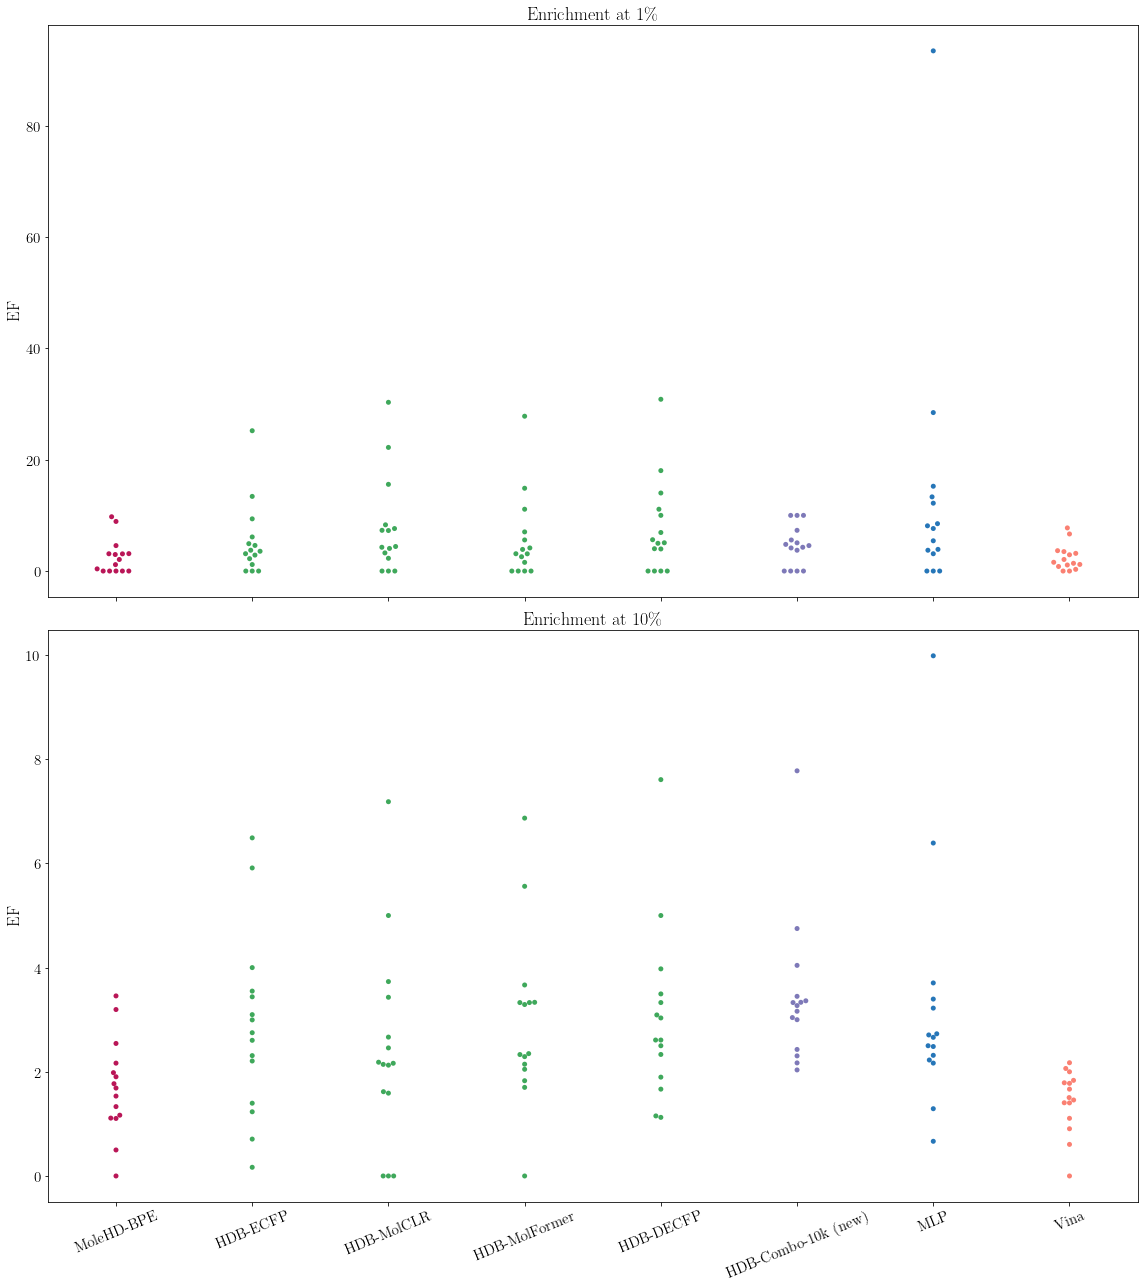

In [24]:
ave_df = compute_model_metric_df(model_dict=model_dict, model_list=model_10k_list, dataset="lit-pcba", split="ave", target_list="all")
ave_df.to_csv("lit-pcba-metrics-10k-ave.csv")

In [8]:
ave_df.describe()

,enrich,p,seed,roc-auc
count,4080.000000,4080.000000,4050.000000,4050.000000
mean,5.638997,0.055000,4.407407,0.669851
std,10.590306,0.045006,2.871143,0.124354
min,0.000000,0.010000,0.000000,0.334528
25%,1.192441,0.010000,2.000000,0.582508
50%,2.937166,0.055000,4.000000,0.649786
75%,5.173105,0.100000,7.000000,0.750903
max,99.902813,0.100000,9.000000,1.000000


In [9]:
ave_df.groupby(["model", "p"]).median()

enrich  seed   roc-auc
model                             p                              
Vina                              0.01   1.572884   NaN       NaN
                                  0.10   1.505012   NaN       NaN
hdbind-directecfp-100k-4          0.01   5.076555   4.5  0.703237
                                  0.10   3.328244   4.5  0.703237
hdbind-directecfp-10k-4           0.01   5.076555   4.5  0.661120
                                  0.10   2.820921   4.5  0.661120
hdbind-directecfp-1k-4            0.01   2.176829   4.5  0.620945
                                  0.10   1.874892   4.5  0.620945
hdbind-directecfp-1m-4            0.01  10.547312   4.5  0.734973
                                  0.10   3.328571   4.5  0.734973
hdbind-molformer-decfp-combo      0.01   4.234912   4.5  0.686784
                                  0.10   3.328244   4.5  0.686784
hdbind-molformer-decfp-combo-100k 0.01  16.656790   4.5  0.735399
                                  0.10   5.000000   4.5  0.735399
hdbind-molformer-decfp-combo-1k   0.01   1.468583   4.5  0.615584
                                  0.10   1.678819   4.5  0.615584
hdbind-molformer-decfp-combo-1m   0.01  16.656790   2.0  0.754859
                                  0.10   5.167244   2.0  0.754859
hdbind-rp-ecfp-1024-1             0.01   4.150100   4.5  0.663273
                                  0.10   2.554650   4.5  0.663273
hdbind-rp-molclr                  0.01   5.076555   4.5  0.643339
                                  0.10   2.206951   4.5  0.643339
hdbind-rp-molformer               0.01   3.879829   4.5  0.638319
                                  0.10   2.499093   4.5  0.638319
hdbind-rp-molformer-ecfp-combo    0.01   2.586553   4.5  0.702102
                                  0.10   2.230463   4.5  0.702102
mlp-1024-1                        0.01   7.272727   4.5  0.621083
                                  0.10   2.695444   4.5  0.621083
molehd-bpe                        0.01   1.515152   4.5  0.580638
                                  0.10   1.687668   4.5  0.580638

492947 ADRB2
train_actives.shape (13, 3) train_inactives.shape (234363, 3) test_actives.shape (4, 3) test_inactives.shape (78120, 3)
dock_actives.shape (128, 23) dock_inactives.shape (2499856, 23)
dock_actives.shape (128, 24) dock_inactives.shape (2499856, 24)
active_lig_map_df.shape (16, 7) inactive_lig_map_df.shape (312482, 7)
active_df.shape (128, 31) inactive_df.shape (2499856, 31)
test_active_df.shape (32, 36) test_inactive_df.shape (628328, 36)
test_data size (628360, 36) (78441,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1030 ALDH1
train_actives.shape (4032, 3) train_inactives.shape (77606, 3) test_actives.shape (1344, 3) test_inactives.shape (25868, 3)
dock_actives.shape (57336, 23) dock_inactives.shape (1103712, 23)
dock_actives.shape (57336, 24) dock_inactives.shape (1103712, 24)
active_lig_map_df.shape (7167, 7) inactive_lig_map_df.shape (137964, 7)
active_df.shape (57336, 31) inactive_df.shape (1103712, 31)
test_active_df.shape (10832, 36) test_inactive_df.shape (217136, 36)
test_data size (227968, 36) (28021,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743075 ESR1_ago
train_actives.shape (10, 3) train_inactives.shape (4188, 3) test_actives.shape (3, 3) test_inactives.shape (1395, 3)
dock_actives.shape (180, 23) dock_inactives.shape (83730, 23)
dock_actives.shape (180, 24) dock_inactives.shape (83730, 24)
active_lig_map_df.shape (12, 7) inactive_lig_map_df.shape (5582, 7)
active_df.shape (180, 31) inactive_df.shape (83730, 31)
test_active_df.shape (90, 36) test_inactive_df.shape (33240, 36)
test_data size (33330, 36) (1954,)

743080 ESR1_ant


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (77, 3) train_inactives.shape (3711, 3) test_actives.shape (25, 3) test_inactives.shape (1237, 3)
dock_actives.shape (1515, 23) dock_inactives.shape (74205, 23)
dock_actives.shape (1515, 24) dock_inactives.shape (74205, 24)
active_lig_map_df.shape (101, 7) inactive_lig_map_df.shape (4947, 7)
active_df.shape (1515, 31) inactive_df.shape (74205, 31)
test_active_df.shape (645, 36) test_inactive_df.shape (29760, 36)
test_data size (30405, 36) (1762,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



588795 FEN1
train_actives.shape (277, 3) train_inactives.shape (266552, 3) test_actives.shape (92, 3) test_inactives.shape (88850, 3)
dock_actives.shape (368, 23) dock_inactives.shape (355401, 23)
dock_actives.shape (368, 24) dock_inactives.shape (355401, 24)
active_lig_map_df.shape (368, 7) inactive_lig_map_df.shape (355401, 7)
active_df.shape (368, 31) inactive_df.shape (355401, 31)
test_active_df.shape (102, 36) test_inactive_df.shape (91307, 36)
test_data size (91409, 36) (90764,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



2101 GBA
train_actives.shape (125, 3) train_inactives.shape (222039, 3) test_actives.shape (41, 3) test_inactives.shape (74013, 3)
dock_actives.shape (990, 23) dock_inactives.shape (1776306, 23)
dock_actives.shape (990, 24) dock_inactives.shape (1776306, 24)
active_lig_map_df.shape (165, 7) inactive_lig_map_df.shape (296051, 7)
active_df.shape (990, 31) inactive_df.shape (1776306, 31)
test_active_df.shape (294, 36) test_inactive_df.shape (468588, 36)
test_data size (468882, 36) (76357,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



602179 IDH1
train_actives.shape (30, 3) train_inactives.shape (271537, 3) test_actives.shape (9, 3) test_inactives.shape (90512, 3)
dock_actives.shape (532, 23) dock_inactives.shape (5068672, 23)
dock_actives.shape (532, 24) dock_inactives.shape (5068672, 24)
active_lig_map_df.shape (38, 7) inactive_lig_map_df.shape (362048, 7)
active_df.shape (532, 31) inactive_df.shape (5068672, 31)
test_active_df.shape (140, 36) test_inactive_df.shape (1289946, 36)
test_data size (1290086, 36) (91744,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



504327 KAT2A
train_actives.shape (146, 3) train_inactives.shape (261411, 3) test_actives.shape (48, 3) test_inactives.shape (87137, 3)
dock_actives.shape (579, 23) dock_inactives.shape (1045641, 23)
dock_actives.shape (579, 24) dock_inactives.shape (1045641, 24)
active_lig_map_df.shape (193, 7) inactive_lig_map_df.shape (348547, 7)
active_df.shape (579, 31) inactive_df.shape (1045641, 31)
test_active_df.shape (162, 36) test_inactive_df.shape (272367, 36)
test_data size (272529, 36) (89637,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



995 MAPK1
train_actives.shape (231, 3) train_inactives.shape (46972, 3) test_actives.shape (77, 3) test_inactives.shape (15657, 3)
dock_actives.shape (4605, 23) dock_inactives.shape (939420, 23)
dock_actives.shape (4605, 24) dock_inactives.shape (939420, 24)
active_lig_map_df.shape (307, 7) inactive_lig_map_df.shape (62628, 7)
active_df.shape (4605, 31) inactive_df.shape (939420, 31)
test_active_df.shape (1155, 36) test_inactive_df.shape (245190, 36)
test_data size (246345, 36) (16193,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



493208 MTORC1
train_actives.shape (73, 3) train_inactives.shape (24729, 3) test_actives.shape (24, 3) test_inactives.shape (8243, 3)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:24: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dock_inactives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-inactives.csv")


dock_actives.shape (1056, 23) dock_inactives.shape (362681, 23)
dock_actives.shape (1056, 24) dock_inactives.shape (362681, 24)
active_lig_map_df.shape (96, 7) inactive_lig_map_df.shape (32971, 7)
active_df.shape (1056, 31) inactive_df.shape (362681, 31)
test_active_df.shape (264, 36) test_inactive_df.shape (90684, 36)
test_data size (90948, 36) (8268,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1777 OPRK1
train_actives.shape (18, 3) train_inactives.shape (202362, 3) test_actives.shape (6, 3) test_inactives.shape (67454, 3)
dock_actives.shape (23, 23) dock_inactives.shape (269815, 23)
dock_actives.shape (23, 24) dock_inactives.shape (269815, 24)
active_lig_map_df.shape (23, 7) inactive_lig_map_df.shape (269815, 7)
active_df.shape (23, 31) inactive_df.shape (269815, 31)
test_active_df.shape (5, 36) test_inactive_df.shape (67626, 36)
test_data size (67631, 36) (67595,)

1631 PKM2


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (410, 3) train_inactives.shape (184143, 3) test_actives.shape (136, 3) test_inactives.shape (61380, 3)
dock_actives.shape (4905, 23) dock_inactives.shape (2209698, 23)
dock_actives.shape (4905, 24) dock_inactives.shape (2209698, 24)
active_lig_map_df.shape (545, 7) inactive_lig_map_df.shape (245522, 7)
active_df.shape (4905, 31) inactive_df.shape (2209698, 31)
test_active_df.shape (1224, 36) test_inactive_df.shape (556614, 36)
test_data size (557838, 36) (61857,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743094 PPARG
train_actives.shape (21, 3) train_inactives.shape (3909, 3) test_actives.shape (6, 3) test_inactives.shape (1302, 3)
dock_actives.shape (390, 23) dock_inactives.shape (78150, 23)
dock_actives.shape (390, 24) dock_inactives.shape (78150, 24)
active_lig_map_df.shape (26, 7) inactive_lig_map_df.shape (5210, 7)
active_df.shape (390, 31) inactive_df.shape (78150, 31)
test_active_df.shape (180, 36) test_inactive_df.shape (32010, 36)
test_data size (32190, 36) (1829,)

651631 TP53
train_actives.shape (60, 3) train_inactives.shape (3126, 3) test_actives.shape (19, 3) test_inactives.shape (1042, 3)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


dock_actives.shape (468, 23) dock_inactives.shape (25002, 23)
dock_actives.shape (468, 24) dock_inactives.shape (25002, 24)
active_lig_map_df.shape (78, 7) inactive_lig_map_df.shape (4167, 7)
active_df.shape (468, 31) inactive_df.shape (25002, 31)
test_active_df.shape (144, 36) test_inactive_df.shape (9816, 36)
test_data size (9960, 36) (1436,)

504847 VDR


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (498, 3) train_inactives.shape (199906, 3) test_actives.shape (165, 3) test_inactives.shape (66635, 3)
dock_actives.shape (1766, 23) dock_inactives.shape (710774, 23)
dock_actives.shape (1766, 24) dock_inactives.shape (710774, 24)
active_lig_map_df.shape (883, 7) inactive_lig_map_df.shape (355387, 7)
active_df.shape (1766, 31) inactive_df.shape (710774, 31)
test_active_df.shape (344, 36) test_inactive_df.shape (138092, 36)
test_data size (138436, 36) (68454,)


/var/tmp/jones289/ipykernel_1573007/4121728138.py:102: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


  0%|          | 0/8 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2-random.5.pkl molehd-bpe


ALDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ALDH1-random.5.pkl molehd-bpe
ESR1_ago /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-random.5.pkl molehd-bpe
ESR1_ant /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-random.5.pkl molehd-bpe
FEN1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-FEN1-random.5.pkl molehd-bpe


GBA /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-GBA-random.5.pkl molehd-bpe


IDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-IDH1-random.5.pkl molehd-bpe


KAT2A /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-KAT2A-random.5.pkl molehd-bpe


MAPK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-random.5.pkl molehd-bpe
MTORC1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-random.5.pkl molehd-bpe
OPRK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-OPRK1-random.5.pkl molehd-bpe


PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-random.5.pkl molehd-bpe


PPARG /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-random.5.pkl molehd-bpe
TP53 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-random.5.pkl molehd-bpe
VDR /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-VDR-random.5.pkl molehd-bpe


 12%|█▎        | 1/8 [00:03<00:21,  3.08s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-random.5.pkl hdbind-rp-ecfp-1024-1


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-random.5.pkl hdbind-rp-ecfp-1024-1
ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-ecfp-1024-1
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-ecfp-1024-1
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-random.5.pkl hdbind-rp-ecfp-1024-1


GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-random.5.pkl hdbind-rp-ecfp-1024-1


IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-random.5.pkl hdbind-rp-ecfp-1024-1


KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-random.5.pkl hdbind-rp-ecfp-1024-1


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-random.5.pkl hdbind-rp-ecfp-1024-1
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-random.5.pkl hdbind-rp-ecfp-1024-1
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-random.5.pkl hdbind-rp-ecfp-1024-1


PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-random.5.pkl hdbind-rp-ecfp-1024-1


PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-random.5.pkl hdbind-rp-ecfp-1024-1
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-random.5.pkl hdbind-rp-ecfp-1024-1
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-random.5.pkl hdbind-rp-ecfp-1024-1


 25%|██▌       | 2/8 [00:06<00:19,  3.26s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ADRB2-random.5.pkl hdbind-rp-molclr


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ALDH1-random.5.pkl hdbind-rp-molclr
ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-molclr
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-molclr
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-FEN1-random.5.pkl hdbind-rp-molclr


GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-GBA-random.5.pkl hdbind-rp-molclr


IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-IDH1-random.5.pkl hdbind-rp-molclr


KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-KAT2A-random.5.pkl hdbind-rp-molclr


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-MAPK1-random.5.pkl hdbind-rp-molclr
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-MTORC1-random.5.pkl hdbind-rp-molclr
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-OPRK1-random.5.pkl hdbind-rp-molclr


PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-PKM2-random.5.pkl hdbind-rp-molclr


PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-PPARG-random.5.pkl hdbind-rp-molclr
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-TP53-random.5.pkl hdbind-rp-molclr
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-VDR-random.5.pkl hdbind-rp-molclr


 38%|███▊      | 3/8 [00:09<00:16,  3.27s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-random.5.pkl hdbind-rp-molformer


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-random.5.pkl hdbind-rp-molformer
ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-molformer
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-molformer
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-random.5.pkl hdbind-rp-molformer


GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-random.5.pkl hdbind-rp-molformer
IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-random.5.pkl hdbind-rp-molformer


KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-random.5.pkl hdbind-rp-molformer


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-random.5.pkl hdbind-rp-molformer
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-random.5.pkl hdbind-rp-molformer
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-random.5.pkl hdbind-rp-molformer


PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-random.5.pkl hdbind-rp-molformer
PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-random.5.pkl hdbind-rp-molformer
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-random.5.pkl hdbind-rp-molformer


 50%|█████     | 4/8 [00:11<00:10,  2.74s/it]

VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-random.5.pkl hdbind-rp-molformer


ADRB2 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-ADRB2-random.5.pkl hdbind-directecfp-10k-4


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-ALDH1-random.5.pkl hdbind-directecfp-10k-4
ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-ESR1_ago-random.5.pkl hdbind-directecfp-10k-4
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-ESR1_ant-random.5.pkl hdbind-directecfp-10k-4
FEN1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-FEN1-random.5.pkl hdbind-directecfp-10k-4


GBA /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-GBA-random.5.pkl hdbind-directecfp-10k-4


IDH1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-IDH1-random.5.pkl hdbind-directecfp-10k-4


KAT2A /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-KAT2A-random.5.pkl hdbind-directecfp-10k-4


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-MAPK1-random.5.pkl hdbind-directecfp-10k-4
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-MTORC1-random.5.pkl hdbind-directecfp-10k-4
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-OPRK1-random.5.pkl hdbind-directecfp-10k-4


PKM2 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-PKM2-random.5.pkl hdbind-directecfp-10k-4


PPARG /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-PPARG-random.5.pkl hdbind-directecfp-10k-4
TP53 /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-TP53-random.5.pkl hdbind-directecfp-10k-4
VDR /p/vast1/jones289/hd_results/5/hdbind-directecfp-10k-4.lit-pcba-VDR-random.5.pkl hdbind-directecfp-10k-4


 62%|██████▎   | 5/8 [00:15<00:08,  2.97s/it]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-ADRB2-random.5.pkl hdbind-molformer-decfp-combo


ALDH1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-ALDH1-random.5.pkl hdbind-molformer-decfp-combo


ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-ESR1_ago-random.5.pkl hdbind-molformer-decfp-combo
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-ESR1_ant-random.5.pkl hdbind-molformer-decfp-combo
FEN1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-FEN1-random.5.pkl hdbind-molformer-decfp-combo


GBA /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-GBA-random.5.pkl hdbind-molformer-decfp-combo


IDH1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-IDH1-random.5.pkl hdbind-molformer-decfp-combo


KAT2A /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-KAT2A-random.5.pkl hdbind-molformer-decfp-combo


MAPK1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-MAPK1-random.5.pkl hdbind-molformer-decfp-combo
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-MTORC1-random.5.pkl hdbind-molformer-decfp-combo
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-OPRK1-random.5.pkl hdbind-molformer-decfp-combo


PKM2 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-PKM2-random.5.pkl hdbind-molformer-decfp-combo


PPARG /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-PPARG-random.5.pkl hdbind-molformer-decfp-combo
TP53 /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-TP53-random.5.pkl hdbind-molformer-decfp-combo
VDR /p/vast1/jones289/hd_results/5/hdbind-molformer-decfp-combo.lit-pcba-VDR-random.5.pkl hdbind-molformer-decfp-combo


 75%|███████▌  | 6/8 [00:19<00:06,  3.30s/it]

ADRB2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ADRB2-random.5.pkl mlp-1024-1


ALDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ALDH1-random.5.pkl mlp-1024-1
ESR1_ago /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ago-random.5.pkl mlp-1024-1
ESR1_ant /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ant-random.5.pkl mlp-1024-1
FEN1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-FEN1-random.5.pkl mlp-1024-1


GBA /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-GBA-random.5.pkl mlp-1024-1


IDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-IDH1-random.5.pkl mlp-1024-1


KAT2A /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-KAT2A-random.5.pkl mlp-1024-1


MAPK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MAPK1-random.5.pkl mlp-1024-1
MTORC1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MTORC1-random.5.pkl mlp-1024-1
OPRK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-OPRK1-random.5.pkl mlp-1024-1


PKM2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PKM2-random.5.pkl mlp-1024-1
PPARG /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PPARG-random.5.pkl mlp-1024-1
TP53 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-TP53-random.5.pkl mlp-1024-1
VDR /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-VDR-random.5.pkl mlp-1024-1


100%|██████████| 15/15 [00:02<00:00,  6.79it/s]
0it [00:00, ?it/s]/8 [00:21<00:02,  2.95s/it]
100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


['model', 'enrich', 'p', 'target', 'seed', 'roc-auc']
[2100, 2100, 2100, 2100, 2100, 2100]
('Vina', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   2.342352
std     0.00   4.513678
min     0.01   0.000000
25%     0.01   0.568255
50%     0.01   1.081891
75%     0.01   1.556449
max     0.01  17.740519
('Vina', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   1.773536
std    2.872975e-17   1.069648
min    1.000000e-01   0.000000
25%    1.000000e-01   1.175023
50%    1.000000e-01   1.601699
75%    1.000000e-01   2.061838
max    1.000000e-01   4.000000
('hdbind-directecfp-10k-4', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01  30.933643
std     0.00  21.703926
min     0.01   0.000000
25%     0.01  16.177353
50%     0.01  29.974172
75%     0.01  39.319107
max     0.01  83.283951
('hdbind-directecfp-10k-4', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   5.143580
std    2.

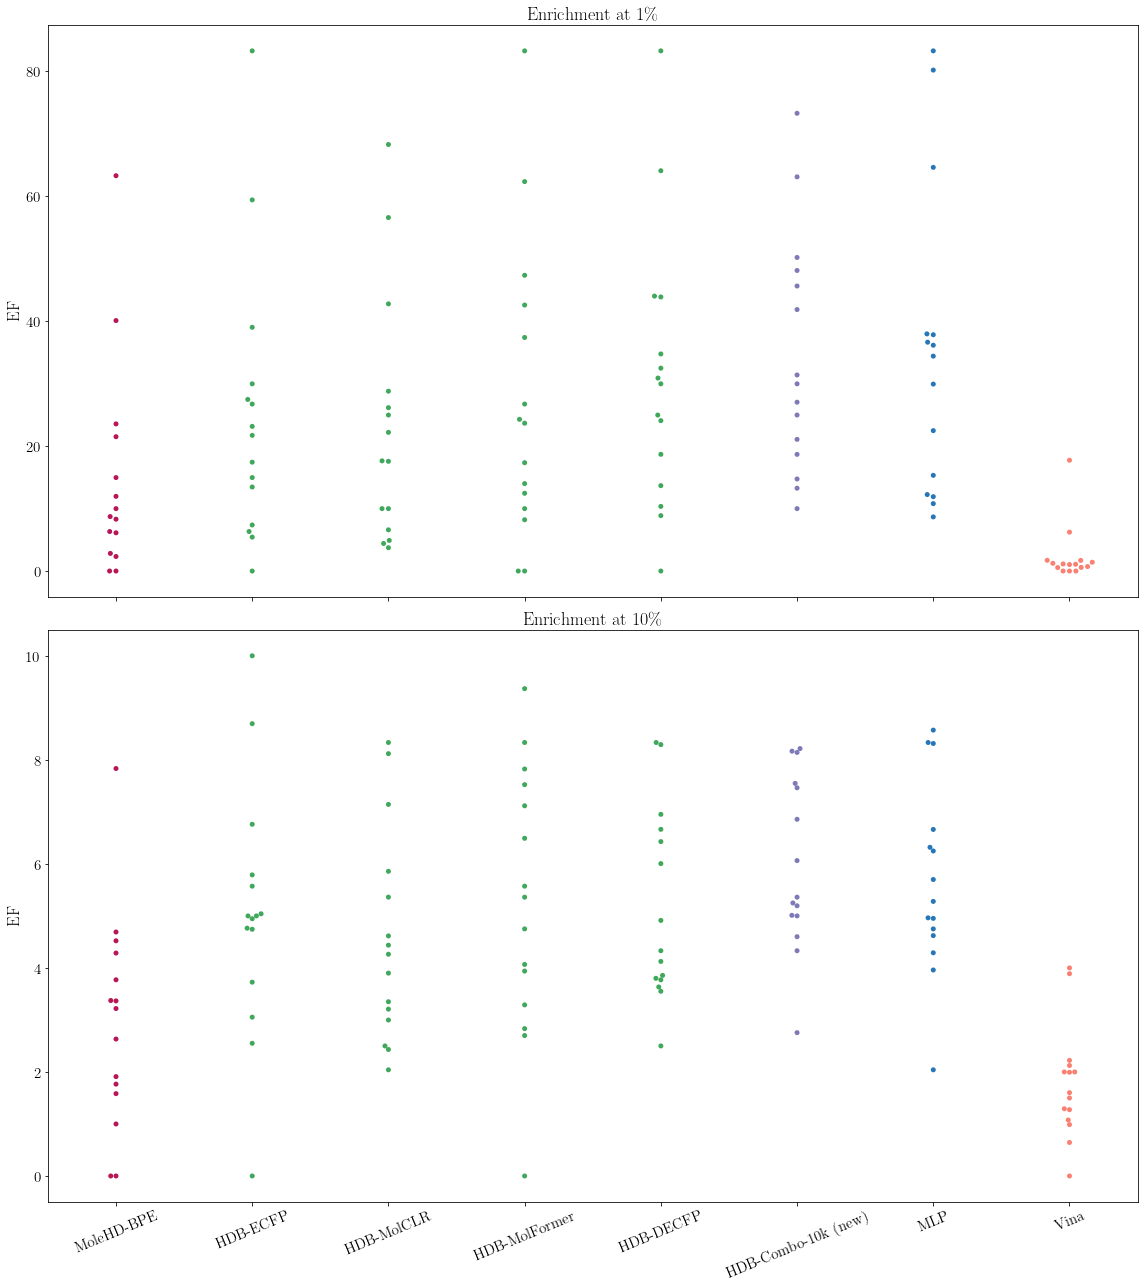

In [25]:
random_df = compute_model_metric_df(model_dict=model_dict, model_list=model_10k_list, dataset="lit-pcba", split="random", target_list="all")
random_df.to_csv("lit-pcba-metrics-10k-random.csv")

In [ ]:
random_df.describe()

In [ ]:
random_df.groupby(["model", "p"]).median()